# Previsão de Séries Temporais com TensorFlow – Single-Step e Multi-Step

Este notebook demonstra:
1. **Leitura e subamostragem** de dados (por exemplo, de 10min para 1h).
2. **Limpeza** e **Engenharia de Atributos** (ex.: vetor de vento, periodicidade).
3. **Normalização** e divisão em **treino/validação/teste**.
4. **Criação de janelas** (`WindowGenerator`) e **Modelos**:
   - *Single-step* (1 hora à frente) 
     - Baseline (retorna o valor atual como previsão)
     - Linear
     - Dense
     - CNN e LSTM (opcional)
   - *Multi-step* (24 horas à frente)
     - Baselines (Last e Repeat)
     - Modelos single-shot (Linear, Dense, CNN, LSTM)
     - Modelo autoregressivo (FeedBack)
5. **Comparação** de desempenhos e conclusões.

Ao final, você terá um pipeline completo para **single-step** e **multi-step** em um único notebook.

## 1) Importação de Bibliotecas

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
sns.set_style('whitegrid')

print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.18.0


## 2) Leitura e Subamostragem
Suponha que o dataset tenha medições a cada 10 minutos, mas queremos uma amostra por hora. Fatiamos (slice) a partir do índice 5, pegando 1 linha a cada 6, resultando em registros de hora em hora.

In [31]:
csv_path = 'jena_climate_2009_2016.csv'

df = pd.read_csv(csv_path)
print("Shape original:", df.shape)
df = df[5::6]  # subamostragem de 10min para 1h
print("Shape após subamostragem (1h):", df.shape)
df.head()

Shape original: (420551, 15)
Shape após subamostragem (1h): (70091, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


### Convertendo Datas para `datetime`
A coluna `'Date Time'` é convertida em `datetime` e removida do `DataFrame`. Vamos armazená-la em `date_time` para usar como índice em plots.

In [32]:
date_time = pd.to_datetime(
    df.pop('Date Time'),
    format='%d.%m.%Y %H:%M:%S'
)
print("Exemplo de date_time:", date_time.head())
df.head()

Exemplo de date_time: 5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


## 3) Exploração e Limpeza Inicial
### 3.1 Estatísticas e Visualização

In [33]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


- `['T (degC)', 'p (mbar)', 'rho (g/m**3)']`: escolhemos temperatura, pressão e densidade para exemplificar a evolução dessas variáveis no tempo.

- No segundo grafico, pegamos apenas as 480 primeiras linhas (ou seja, 480 horas ≈ 20 dias), para ver o comportamento em um intervalo menor. Dessa forma, é possível inspecionar em detalhe como as variáveis mudam em um curto período.

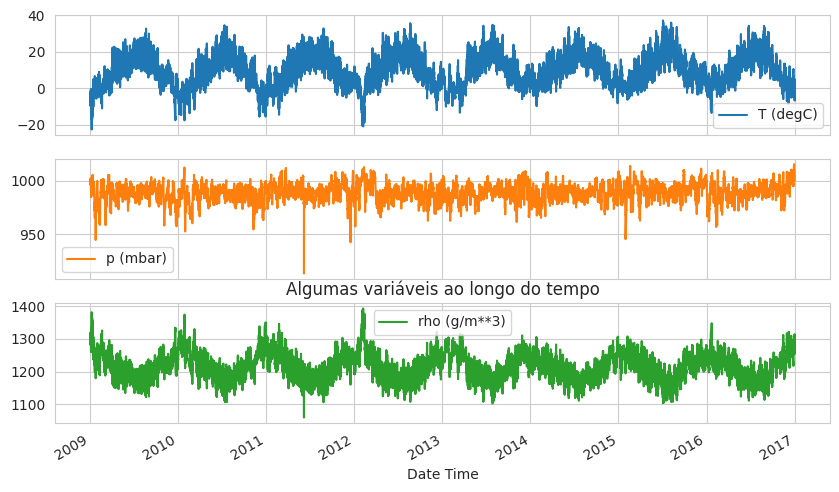

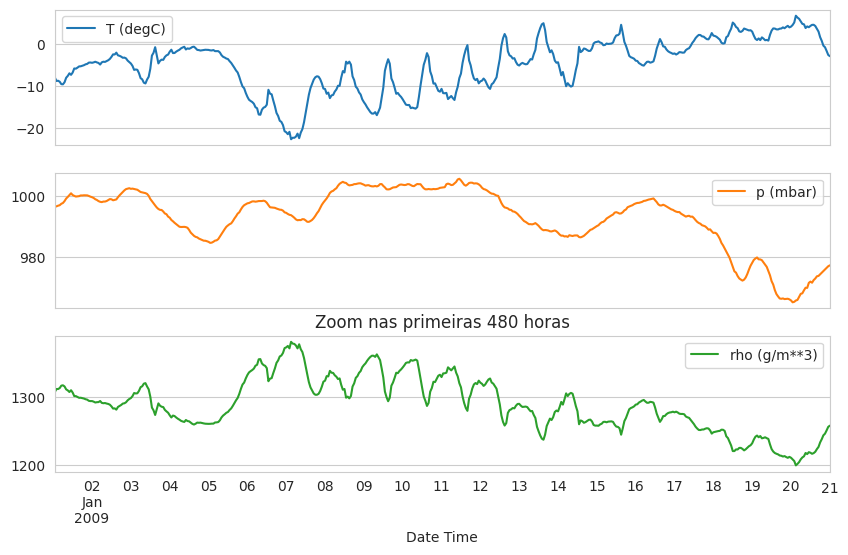

In [34]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols].copy()
plot_features.index = date_time
plot_features.plot(subplots=True)
plt.title("Algumas variáveis ao longo do tempo")
plt.show()

# Zoom nas primeiras 480h
plot_features_zoom = df[plot_cols][:480].copy()
plot_features_zoom.index = date_time[:480]
plot_features_zoom.plot(subplots=True)
plt.title("Zoom nas primeiras 480 horas")
plt.show()

### 3.2 Valores Anômalos (ex.: -9999 em `wv (m/s)`)
Corrigimos valores inválidos substituindo-os por 0.

In [35]:
if 'wv (m/s)' in df.columns:
    bad_wv = df['wv (m/s)'] == -9999.0
    df.loc[bad_wv, 'wv (m/s)'] = 0.0
if 'max. wv (m/s)' in df.columns:
    bad_max_wv = df['max. wv (m/s)'] == -9999.0
    df.loc[bad_max_wv, 'max. wv (m/s)'] = 0.0

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


## 4) Engenharia de Atributos
### 4.1 Vetores de Vento (Wx, Wy)
Transformamos `(velocidade, direção)` em `(Wx, Wy)` para evitar problemas de ângulos (0° e 360°).

In [36]:
import numpy as np

if 'wd (deg)' in df.columns and 'wv (m/s)' in df.columns:
    wv = df.pop('wv (m/s)')
    max_wv = df.pop('max. wv (m/s)') if 'max. wv (m/s)' in df.columns else None
    wd_rad = df.pop('wd (deg)') * np.pi/180

    df['Wx'] = wv*np.cos(wd_rad)
    df['Wy'] = wv*np.sin(wd_rad)
    if max_wv is not None:
        df['max Wx'] = max_wv*np.cos(wd_rad)
        df['max Wy'] = max_wv*np.sin(wd_rad)
    print("Convertidos wd e velocidade para Wx, Wy.")
df.head()

Convertidos wd e velocidade para Wx, Wy.


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843


### 4.2 Capturando Periodicidade Diária e Anual
A coluna de data/hora em si não é diretamente útil como string ou mesmo em segundos, pois se trata de dados sazonais (com variação diária e anual).

#### Sinal Diário:
- Geramos `Day sin/cos` com base em `timestamp_s` (tempo em segundos). Day sin e Day cos usam timestamp_s * (2π / day), que percorre 2π a cada 24h. Assim, cada dia mapeia um ciclo completo de seno e cosseno.
- O modelo pode, então, aprender facilmente a hora do dia: 0h e 24h correspondem a (sin=0, cos=1), meio-dia (~12h) vira (sin=1, cos=0), etc.

#### Sinal Anual:
- `Year sin/cos` fazem o mesmo, mas para o período de 1 ano.
- Assim, ao longo de ~365 dias, `timestamp_s` percorre `2π` no seno e cosseno, capturando a sazonalidade anual (por ex., verão/inverno).

In [37]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = 365.2425*day

df['Day sin'] = np.sin(timestamp_s*(2*np.pi/day))
df['Day cos'] = np.cos(timestamp_s*(2*np.pi/day))
df['Year sin'] = np.sin(timestamp_s*(2*np.pi/year))
df['Year cos'] = np.cos(timestamp_s*(2*np.pi/year))
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


Text(0.5, 1.0, 'Time of day signal')

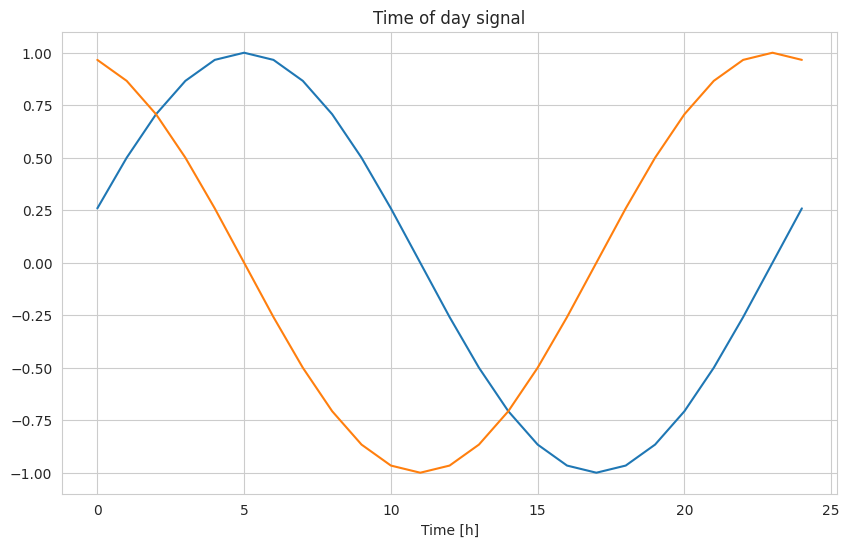

In [38]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Ao plotar as primeiras 25 amostras de `Day sin` e `Day cos` observamos curvas de seno e cosseno defasadas, confirmando essa representação periódica.

Para reforçar essa análise, podemos usar Transformada Rápida de Fourier (FFT) e observar picos em frequências diárias (1/dia) e anuais (1/ano).
- `tf.signal.rfft(df['T (degC)'])` dá a transformada real dos valores de temperatura; ao plotar `np.abs(fft)` em escala logarítmica, vê-se picos nas frequências de 1/ano e 1/dia, como esperado para dados climáticos.

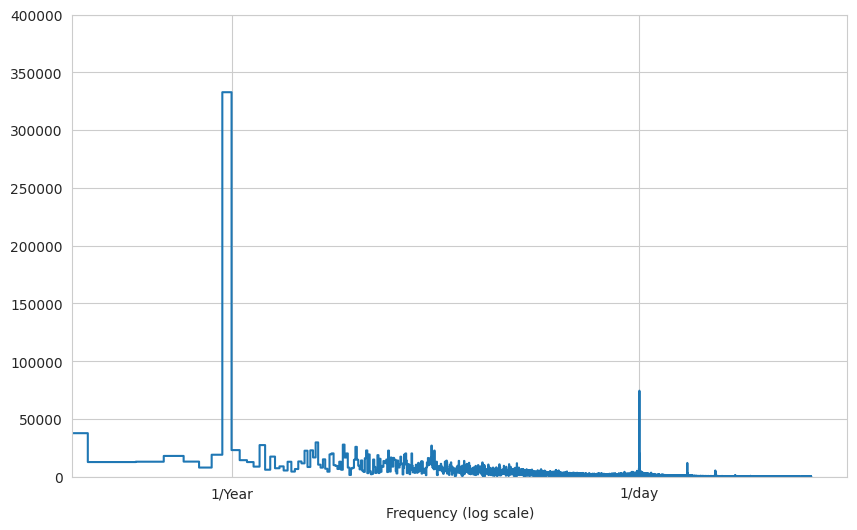

In [39]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## 5) Divisão em Treino/Validação/Teste e Normalização

A escolha de não embaralhar (no shuffle) ocorre por duas razões:

1. **Janelas temporais consecutivas:** embaralhar quebraria a estrutura temporal, inviabilizando a criação de janelas de treino que respeitem a sequência real dos dados.
2. **Avaliação realista:** usar dados futuros para validação e teste simula um cenário de previsão mais próximo do mundo real (o modelo só recebe dados do “passado” para prever dados do “futuro”).

/tmp/ipykernel_729501/520184585.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


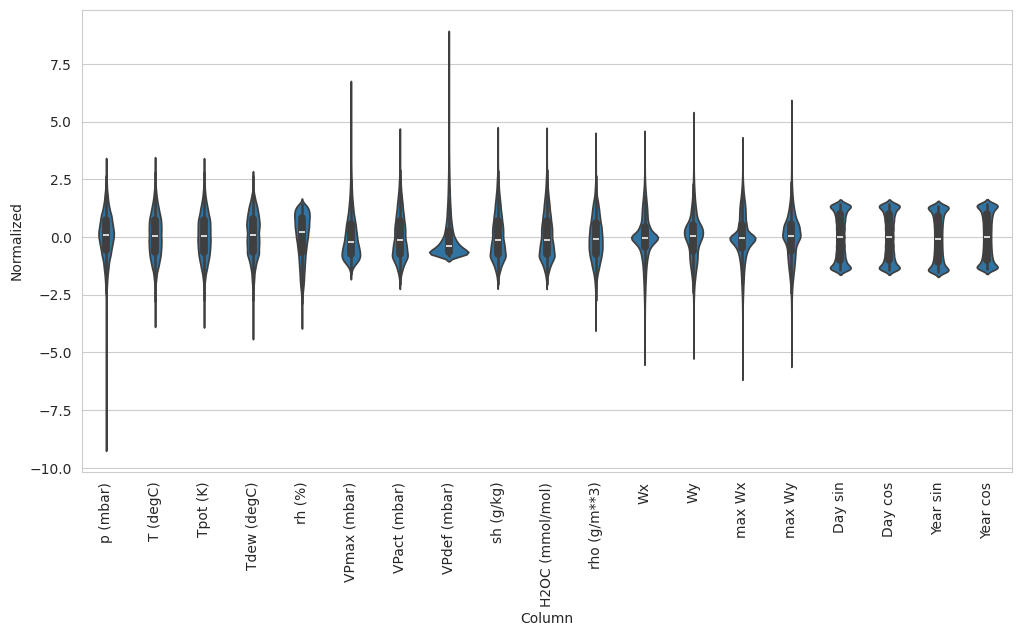

In [40]:
# dicionário mapeando cada nome de coluna (como 'T (degC)', 'p (mbar)', etc.) para um índice inteiro. 
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df) #captura o número total de amostras do dataframe.
train_df = df[:int(n*0.7)] # pega 70% das primeiras linhas para treino.
val_df   = df[int(n*0.7):int(n*0.9)] #pega os 20% seguintes para validação.
test_df  = df[int(n*0.9):]  # pega os 10% finais para teste.

num_features = df.shape[1] #  armazena o número total de colunas do df. Será útil para definir o tamanho de entrada/saída nos modelos.

train_mean = train_df.mean()
train_std  = train_df.std()

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

O violin plot exibe a distribuição dos valores normalizados de cada coluna. Algumas colunas apresentam tails (caudas longas) mais pronunciadas, mas não há valores totalmente anômalos (como o antigo -9999).

Após essa inspeção, normaliza-se **cada subconjunto** (treino, validação e teste) usando `train_mean` e `train_std`:

In [41]:
def normalize(df, mean, std):
    return (df - mean) / std

train_df = normalize(train_df, train_mean, train_std)
val_df   = normalize(val_df, train_mean, train_std)
test_df  = normalize(test_df, train_mean, train_std)

print("Tamanho:", train_df.shape, val_df.shape, test_df.shape)

Tamanho: (49063, 19) (14018, 19) (7010, 19)


> IMPORTANTE:

- Essa padronização gera dados cujos valores, por coluna, aproximam-se de uma distribuição com média 0 e desvio padrão 1 — porém **apenas** baseada nos valores de *treino*.
- Tanto `val_df` quanto `test_df` não devem influenciar as estatísticas usadas; isso garantiria um *leakage* (vazamento de informação) do futuro.

## 5.1) Por que Normalizar Usando Apenas o Treino?

1. **Simula cenário real:**
Em produção, você nunca terá acesso às estatísticas do futuro. A normalização em problemas de time series costuma sempre se basear apenas em dados históricos ou janelas móveis de dados.

2. **Evita *data leakage***:
Se as estatísticas (média e desvio) fossem calculadas em todo o dataset, os dados de validação e teste teriam fornecido informações sobre seu valor médio ou variabilidade ao modelo de alguma forma, influenciando o treino.

3. **Facilita treinamento:**
A normalização estabiliza as escalas dos atributos, ajudando os métodos de otimização (e.g. *gradient descent*) a convergirem mais rapidamente.

## 6) Classe `WindowGenerator`

O objetivo aqui é organizar os dados em janelas (ou windows) para que o modelo possa receber uma sequência de observações recentes (entradas) e produzir uma sequência ou um único valor de saída (rótulos/labels).

In [42]:
class WindowGenerator:
    def __init__(
        self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None
    ):
        # Armazena dataframes crus
        # O construtor recebe os DataFrames de treino, validação e teste para gerar windows de cada um desses conjuntos.
        self.train_df = train_df
        self.val_df   = val_df
        self.test_df  = test_df

        # Armazena as colunas de rótulos
        self.label_columns = label_columns # lista com os nomes das colunas que queremos prever.
        if label_columns is not None: # Se não for None, a classe cria um dicionário label_columns_indices para mapear cada nome de coluna de rótulo para o índice correspondente.
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # mapeia todas as colunas do train_df para seus respectivos índices (0, 1, 2, ...), útil no momento de extrair as colunas corretas do batch de dados.

        # Parâmetros da janela
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # define o fatiamento (range) para as amostras de entrada (vai de 0 até input_width-1).
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width # marca a posição de início dos rótulos dentro de cada janela.
        self.labels_slice = slice(self.label_start, None) # define o slice final para rótulos (do label_start até o fim da janela).
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice] # são arrays com a posição exata de cada passo de entrada e saída, respectivamente.

    # permite que, ao imprimir o objeto, vejamos informações de depuração:
    # tamanho total da janela, quais índices pertencem à entrada e quais pertencem ao rótulo, e quais colunas estamos prevendo.
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

    def split_window(self, features): #Recebe um batch de janelas, com formato (batch, total_window_size, num_features).
        inputs = features[:, self.input_slice, :] # pegamos do índice 0 até input_width-1 ao longo do eixo “tempo”.
        labels = features[:, self.labels_slice, :] # extraindo as posições do tempo que correspondem ao(s) rótulo(s).
 
        if self.label_columns is not None: #(por exemplo, ['T (degC)']), o código empilha somente essas colunas desejadas para o rótulo
            labels = tf.stack([
                labels[:, :, self.column_indices[name]] for name in self.label_columns
            ], axis=-1) 
        #Ajustando a forma (shape) para inspeção
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32) # converte o DataFrame em um array numpy, Tensor.
        ds = tf.keras.utils.timeseries_dataset_from_array( #gera um objeto tf.data.Dataset para dados de séries temporais.
            data=data,
            targets=None, #não definimos rótulos aqui, pois vamos mapeá-los depois com split_window.
            sequence_length=self.total_window_size, #o comprimento total da janela (por ex., 6 + 1 no caso de w2, ou 24 + 24 no caso de w1).
            sequence_stride=1, #cada janela começa apenas 1 passo após a anterior.
            shuffle=True, # embaralha a ordem dos exemplos para evitar correlações na ordem de treino.
            batch_size=32, # cada batch terá 32 janelas.
        )
        ds = ds.map(self.split_window) # A função self.split_window (definida anteriormente) pega cada janela (tensor) e retorna (inputs, labels) com os formatos corretos.
        return ds #é um tf.data.Dataset onde cada elemento é (inputs, labels), pronto para ser consumido pelo modelo.
    
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            # Rótulos (Labels)
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            # Se um modelo for passado, também plota as previsões
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

# 7) **Single-step Models**
Nessa etapa, queremos prever **apenas 1 hora** à frente, com base em 1 hora (ou várias horas) de histórico.

### 7.1 Exemplo de janela single-step (input_width=1, label_width=1, shift=1)

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


2024-12-27 21:12:37.662109: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


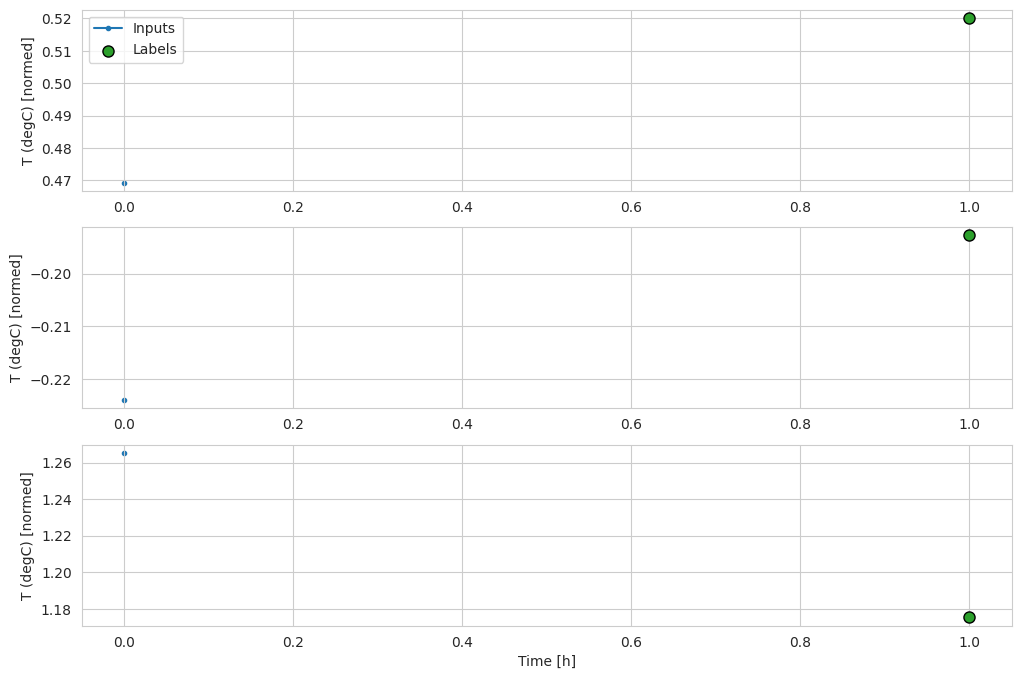

In [43]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df
)
print(single_step_window)
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

single_step_window.plot()

### 7.2 Baseline para Single-step
Podemos criar um *baseline* que retorna sempre o valor atual da temperatura como previsão, assumindo que ela não mudará na próxima hora.

In [44]:
val_performance = {}
performance = {}

class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

# Instancia
baseline = Baseline(label_index=train_df.columns.get_loc('T (degC)'))
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae'] #tf.keras.metrics.MeanAbsoluteError()
)

val_performance['Baseline'] = baseline.evaluate(
    single_step_window.val,
    return_dict=True
)
performance['Baseline'] = baseline.evaluate(
    single_step_window.test,
    verbose=0,
    return_dict=True
)
val_performance['Baseline']

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0131 - mae: 0.0785


{'loss': 0.012845642864704132, 'mae': 0.07846633344888687}

### 7.3 Modelo Linear (Single-step)
Aplicamos uma **camada densa sem ativação** diretamente entre o input e a previsão.

In [45]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['mae']
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )
    return history

# Modelo Linear single-step
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(
    single_step_window.val,
    return_dict=True
)
performance['Linear'] = linear.evaluate(
    single_step_window.test,
    verbose=0,
    return_dict=True
)
val_performance['Linear']

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3058 - mae: 0.7569 - val_loss: 0.0475 - val_mae: 0.1669
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0405 - mae: 0.1526 - val_loss: 0.0187 - val_mae: 0.1035
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0162 - mae: 0.0951 - val_loss: 0.0098 - val_mae: 0.0734
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098 - mae: 0.0725 - val_loss: 0.0090 - val_mae: 0.0699
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0093 - mae: 0.0703 - val_loss: 0.0088 - val_mae: 0.0691
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0092 - mae: 0.0699 - val_loss: 0.0088 - val_mae: 0.0692
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0092 - mae: 0.0698 - val_loss: 0.0087 - val_mae: 0.0688
Epoch 8/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0092 - mae: 0.0698 - val_loss: 0.0089 - val_mae: 0.0696
Epoch 9/20
1534/1534 ━━━━━━━━━━━━━━━━━━━

{'loss': 0.008821744471788406, 'mae': 0.06976601481437683}

### 7.4 Modelo Denso (Single-step)
Empilhamos algumas camadas Dense (relu) para maior capacidade de aprendizado, mas ainda com 1 hora de horizonte.

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(
    single_step_window.val,
    return_dict=True
)
performance['Dense'] = dense.evaluate(
    single_step_window.test,
    verbose=0,
    return_dict=True
)
val_performance['Dense']

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0516 - mae: 0.1199 - val_loss: 0.0084 - val_mae: 0.0683
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0081 - mae: 0.0649 - val_loss: 0.0081 - val_mae: 0.0664
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0076 - mae: 0.0627 - val_loss: 0.0067 - val_mae: 0.0582
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0073 - mae: 0.0612 - val_loss: 0.0066 - val_mae: 0.0573
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0071 - mae: 0.0596 - val_loss: 0.0068 - val_mae: 0.0595
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0070 - mae: 0.0594 - val_loss: 0.0066 - val_mae: 0.0578
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0069 - mae: 0.0589


{'loss': 0.006628026254475117, 'mae': 0.05780162289738655}

## 8) Modelos Multi-step (24h no futuro)
Agora, passamos a prever **24 horas** no futuro com base em 24 horas passadas. 
### 8.1 Criação da Janela Multi-step

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None


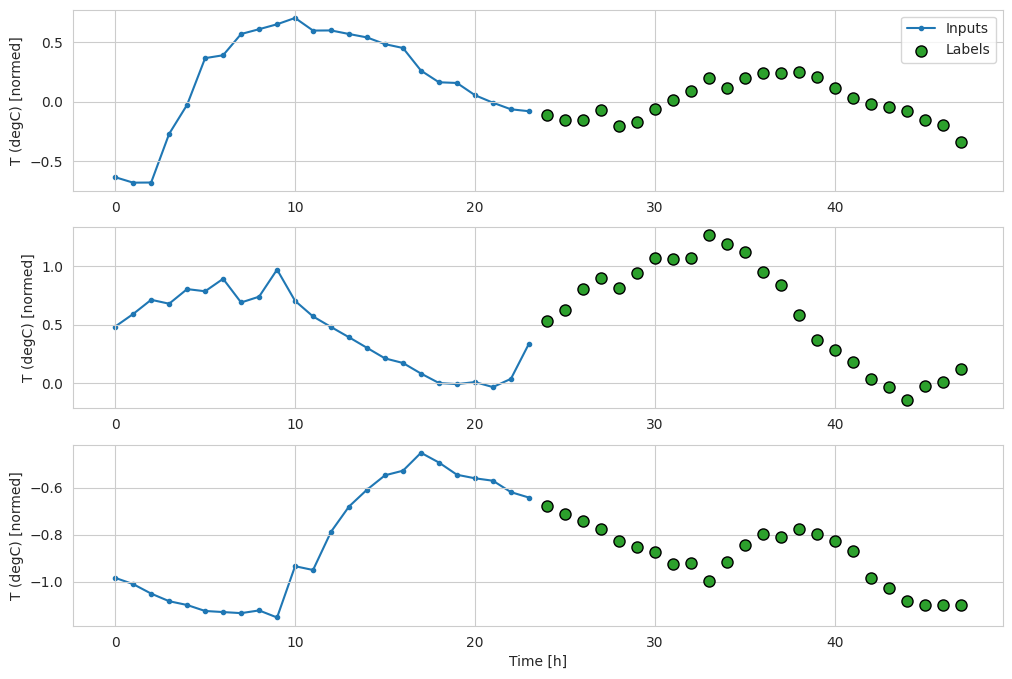

In [47]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=None  # => prever todas as colunas
)
print(multi_window)
multi_window.plot()

### 8.2 Baselines Multi-step (Last e Repeat)
1. **MultiStepLastBaseline**: repete o último valor para as 24 horas de saída
2. **RepeatBaseline**: repete todo o histórico de 24h como se o dia seguinte fosse igual ao anterior

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6301 - mae: 0.5011


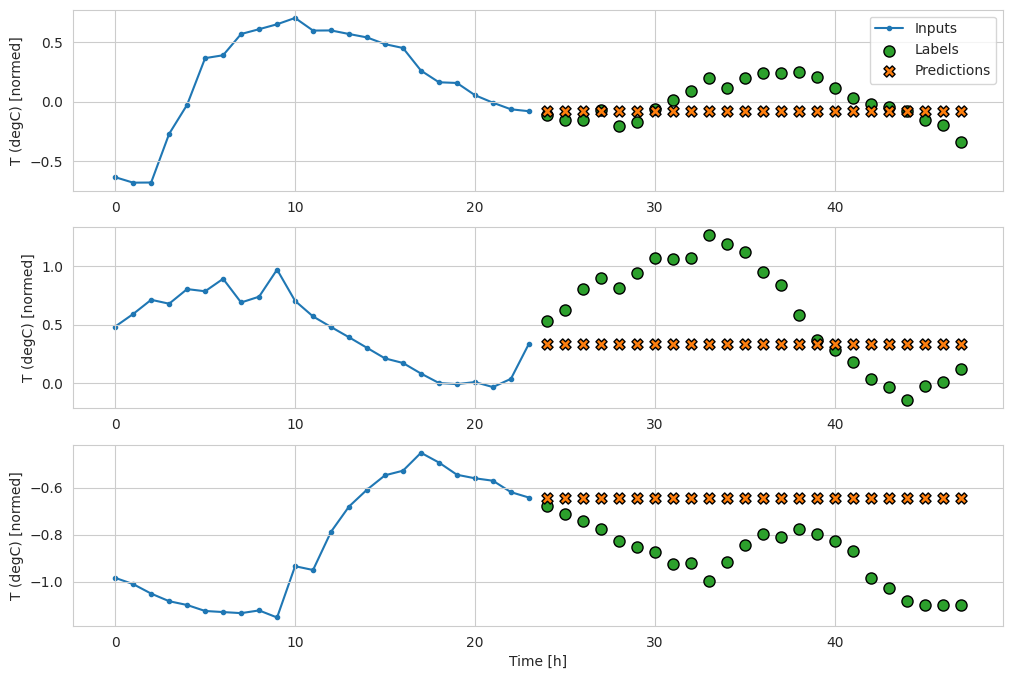

In [48]:
multi_val_performance = {}
multi_performance = {}

class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

# Last
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss='mse', metrics=['mae'])
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4257 - mae: 0.3952
Multi-step baselines: {'Last': {'loss': 0.6285410523414612, 'mae': 0.500719428062439}, 'Repeat': {'loss': 0.4270254075527191, 'mae': 0.39587441086769104}}


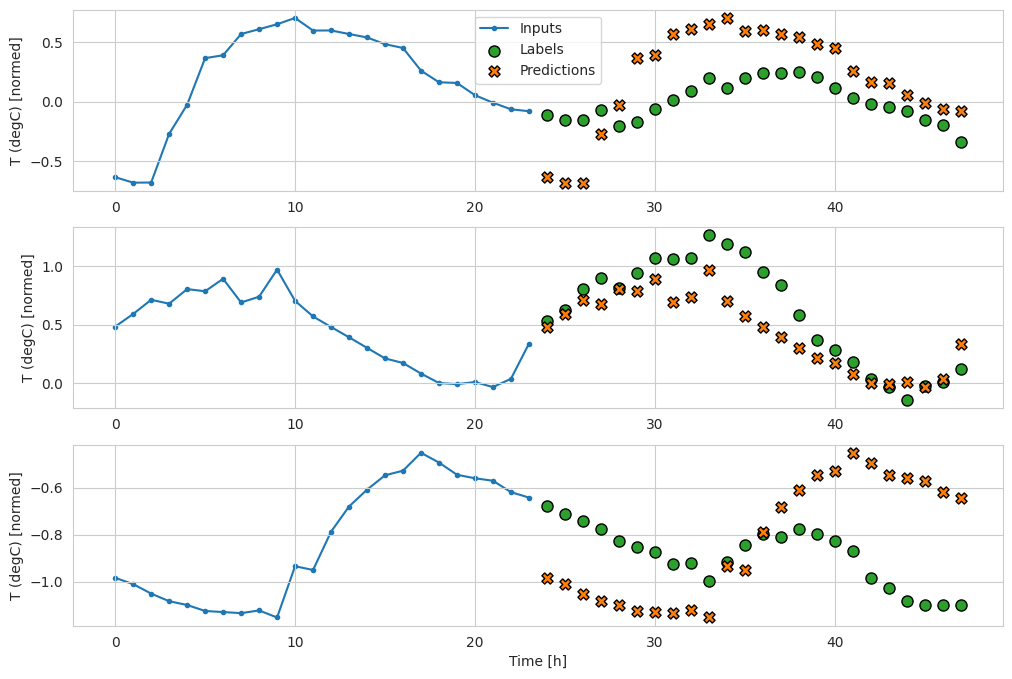

In [49]:
# Repeat
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss='mse', metrics=['mae'])
multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)
print("Multi-step baselines:", multi_val_performance)

### 8.3 Modelos Single-shot multi-step: Linear, Dense, CNN, LSTM

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4318 - mae: 0.4772 - val_loss: 0.2591 - val_mae: 0.3235
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2565 - mae: 0.3164 - val_loss: 0.2560 - val_mae: 0.3062
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2551 - mae: 0.3070 - val_loss: 0.2561 - val_mae: 0.3056
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2550 - mae: 0.3066 - val_loss: 0.2560 - val_mae: 0.3057
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2548 - mae: 0.3065 - val_loss: 0.2561 - val_mae: 0.3057
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2548 - mae: 0.3065 - val_loss: 0.2558 - val_mae: 0.3055
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2548 - mae: 0.3065 - val_loss: 0.2561 - val_mae: 0.3055
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2549 - mae: 0.3065 - val_loss: 0.2560 - val_mae: 0.3055
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

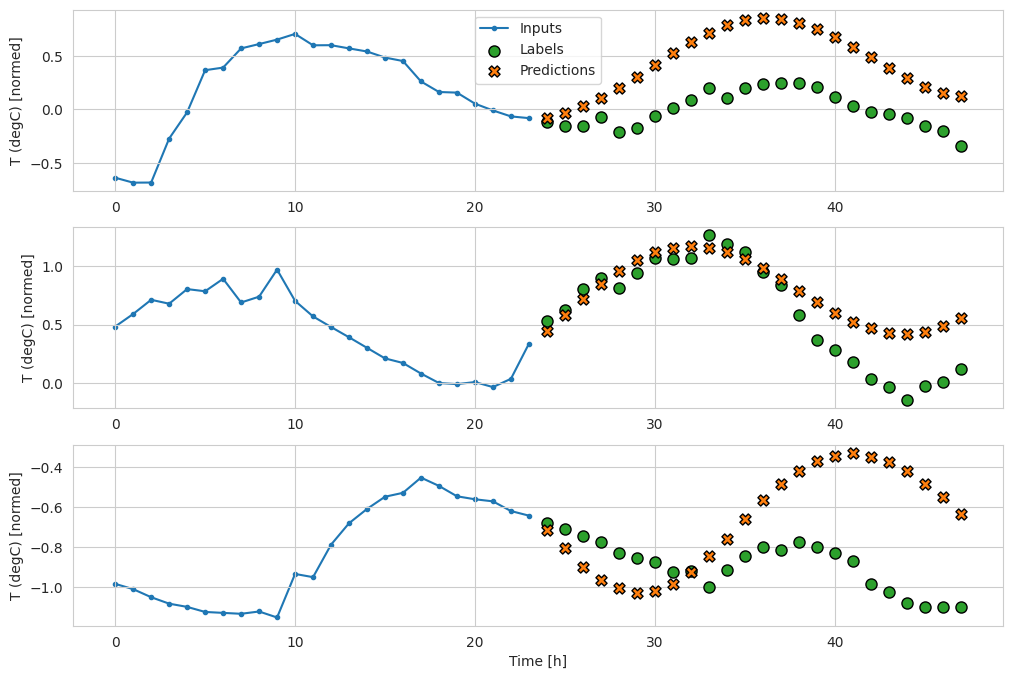

In [50]:
# 1) Multi-step Linear
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(OUT_STEPS * train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_linear_model, multi_window)
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.2776 - mae: 0.3357 - val_loss: 0.2251 - val_mae: 0.2866
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2229 - mae: 0.2853 - val_loss: 0.2224 - val_mae: 0.2849
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2194 - mae: 0.2824 - val_loss: 0.2203 - val_mae: 0.2831
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2163 - mae: 0.2794 - val_loss: 0.2216 - val_mae: 0.2835
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2146 - mae: 0.2783 - val_loss: 0.2199 - val_mae: 0.2818
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2125 - mae: 0.2765 - val_loss: 0.2211 - val_mae: 0.2820
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2115 - mae: 0.2758 - val_loss: 0.2182 - val_mae: 0.2816
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2104 - mae: 0.2750 - val_loss: 0.2185 - val_mae: 0.2800
Epoch 9/20
1532/1532 ━━━━━━━━━━━

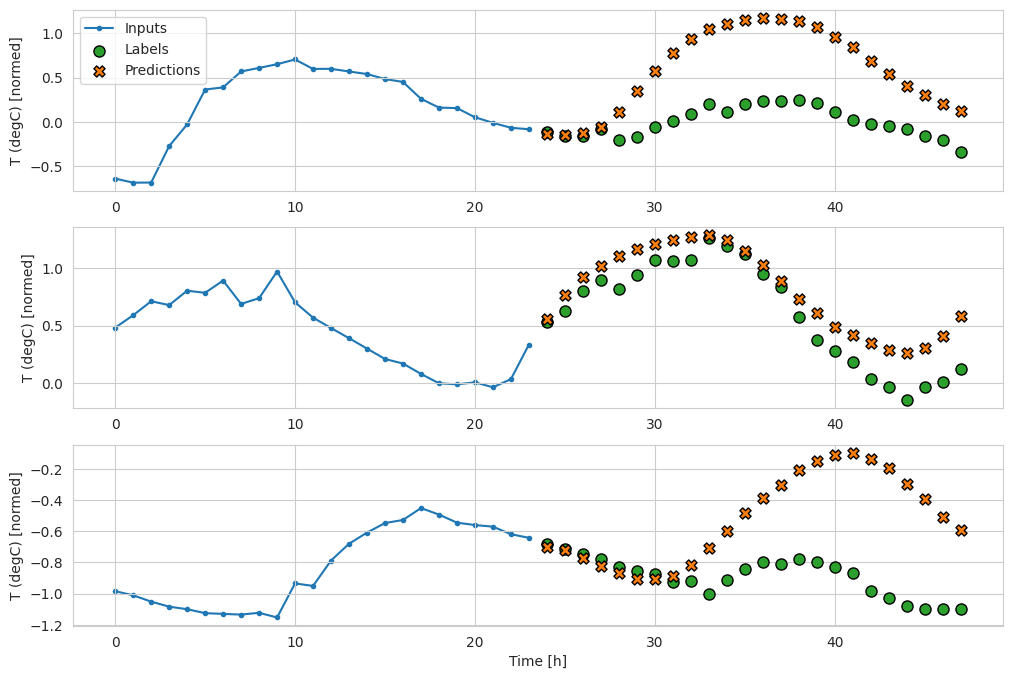

In [51]:
# 2) Multi-step Dense
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_dense_model, multi_window)
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2847 - mae: 0.3450 - val_loss: 0.2242 - val_mae: 0.2886
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2201 - mae: 0.2865 - val_loss: 0.2203 - val_mae: 0.2872
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2165 - mae: 0.2836 - val_loss: 0.2188 - val_mae: 0.2859
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2131 - mae: 0.2805 - val_loss: 0.2154 - val_mae: 0.2814
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2110 - mae: 0.2787 - val_loss: 0.2183 - val_mae: 0.2843
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2093 - mae: 0.2773 - val_loss: 0.2137 - val_mae: 0.2801
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2078 - mae: 0.2758 - val_loss: 0.2158 - val_mae: 0.2819
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2069 - mae: 0.2755 - val_loss: 0.2144 - val_mae: 0.2810
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

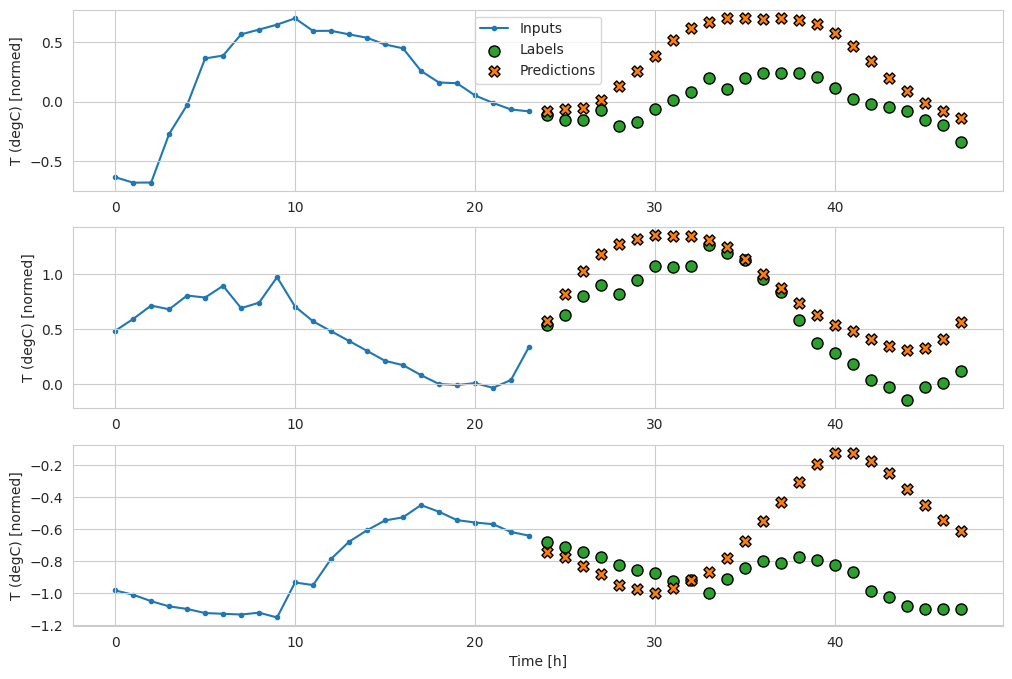

In [52]:
# 3) Multi-step CNN
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, kernel_size=CONV_WIDTH, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.4105 - mae: 0.4502 - val_loss: 0.2305 - val_mae: 0.3062
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2203 - mae: 0.2982 - val_loss: 0.2201 - val_mae: 0.2939
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.2099 - mae: 0.2865 - val_loss: 0.2165 - val_mae: 0.2894
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.2053 - mae: 0.2815 - val_loss: 0.2153 - val_mae: 0.2871
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.2021 - mae: 0.2786 - val_loss: 0.2136 - val_mae: 0.2857
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1997 - mae: 0.2766 - val_loss: 0.2133 - val_mae: 0.2849
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.1979 - mae: 0.2752 - val_loss: 0.2132 - val_mae: 0.2849
Epoch 8/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1960 - mae: 0.2738 - val_loss: 0.2131 - val_mae: 0.2847
Epoch 9/20
1532/1532 ━━━━━━━━━━━

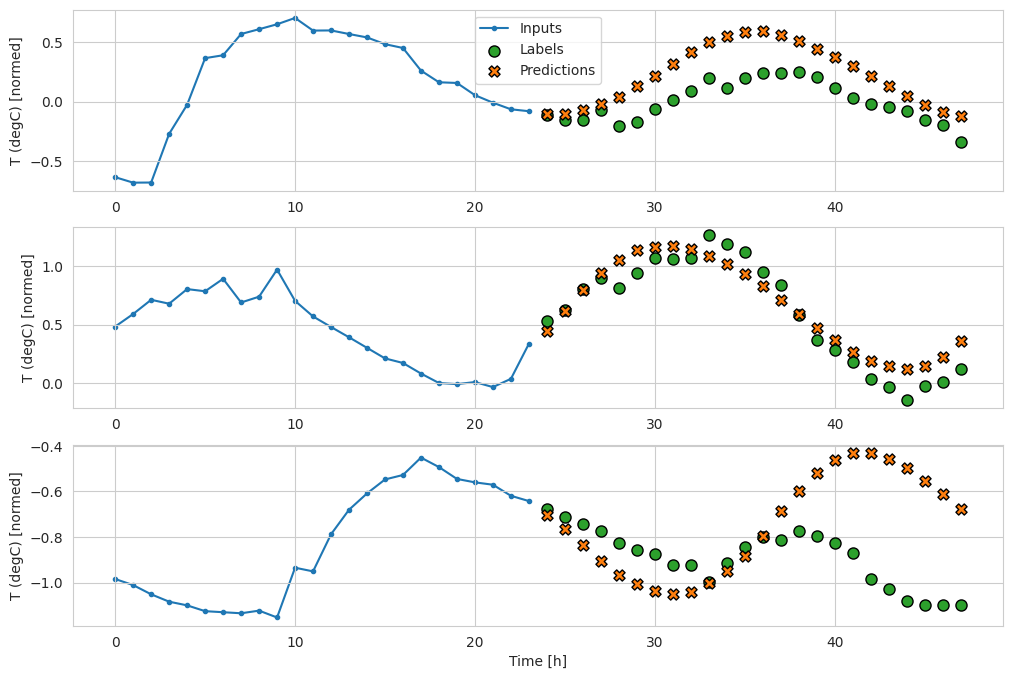

In [53]:
# 4) Multi-step LSTM (single-shot)
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS * train_df.shape[1], kernel_initializer=tf.zeros_initializer()),
    tf.keras.layers.Reshape([OUT_STEPS, train_df.shape[1]])
])

history = compile_and_fit(multi_lstm_model, multi_window)
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

### 8.4 Modelo Autoregressivo
Em vez de produzir toda a sequência de uma vez, esse modelo gera um passo e realimenta a previsão como entrada do próximo passo.

Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.4349 - mae: 0.4699 - val_loss: 0.2518 - val_mae: 0.3330
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2403 - mae: 0.3231 - val_loss: 0.2438 - val_mae: 0.3197
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2262 - mae: 0.3068 - val_loss: 0.2305 - val_mae: 0.3073
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2200 - mae: 0.3001 - val_loss: 0.2340 - val_mae: 0.3082
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2159 - mae: 0.2956 - val_loss: 0.2250 - val_mae: 0.3004
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2117 - mae: 0.2919 - val_loss: 0.2306 - val_mae: 0.3060
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.2095 - mae: 0.2895 - val_loss: 0.2281 - val_mae: 0.3013
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2283 - mae: 0.3019


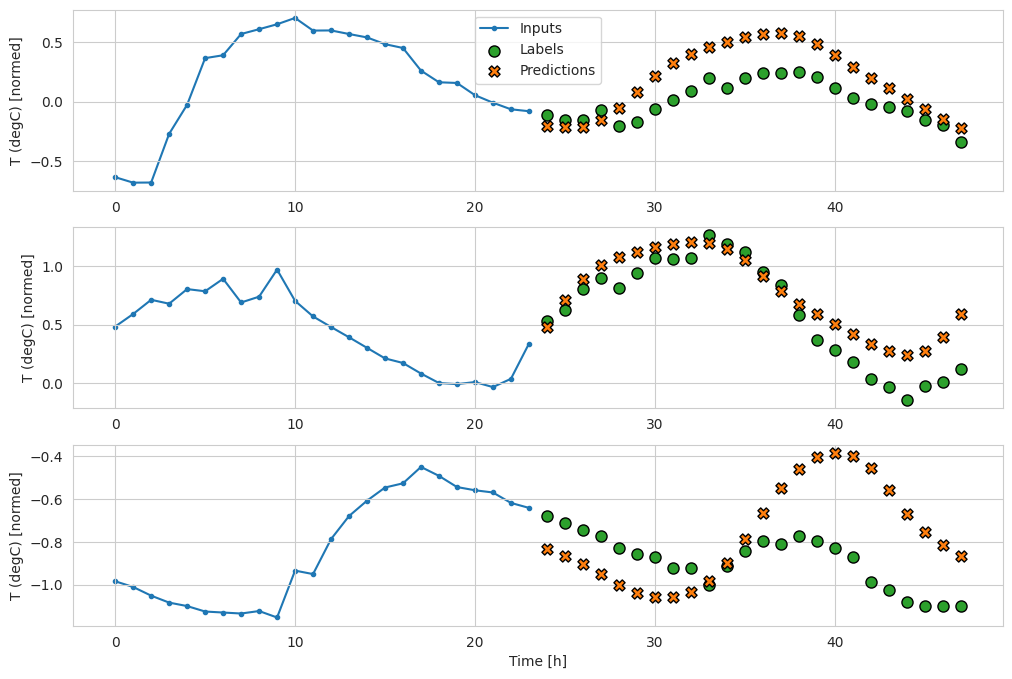

In [54]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.num_features = num_features
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

feedback_model = FeedBack(
    units=32,
    out_steps=OUT_STEPS,
    num_features=train_df.shape[1]
)
history = compile_and_fit(feedback_model, multi_window)
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

## 9) Comparação de Resultados
Consolidamos as métricas em ambos os cenários (single-step e multi-step).

In [63]:
import numpy as np

print("\n=== Single-step Models ===")
for name, val in val_performance.items():
    print(name, "(Val):", val)
for name, testv in performance.items():
    print(name, "(Test):", testv)

print("\n=== Multi-step Models ===")
for name, valv in multi_val_performance.items():
    print(name, "(Val):", valv)
for name, testm in multi_performance.items():
    print(name, "(Test):", testm)



=== Single-step Models ===
Baseline (Val): {'loss': 0.012845642864704132, 'mae': 0.07846633344888687}
Linear (Val): {'loss': 0.008821744471788406, 'mae': 0.06976601481437683}
Dense (Val): {'loss': 0.006628026254475117, 'mae': 0.05780162289738655}
Baseline (Test): {'loss': 0.01416261587291956, 'mae': 0.08516013622283936}
Linear (Test): {'loss': 0.008604190312325954, 'mae': 0.0682012215256691}
Dense (Test): {'loss': 0.006738887168467045, 'mae': 0.05910089612007141}

=== Multi-step Models ===
Last (Val): {'loss': 0.6285410523414612, 'mae': 0.500719428062439}
Repeat (Val): {'loss': 0.4270254075527191, 'mae': 0.39587441086769104}
Linear (Val): {'loss': 0.25602832436561584, 'mae': 0.30548837780952454}
Dense (Val): {'loss': 0.21833238005638123, 'mae': 0.27989041805267334}
Conv (Val): {'loss': 0.21444039046764374, 'mae': 0.28097015619277954}
LSTM (Val): {'loss': 0.21487216651439667, 'mae': 0.2855786681175232}
AR LSTM (Val): {'loss': 0.2280638962984085, 'mae': 0.3012513518333435}
Last (Test): 

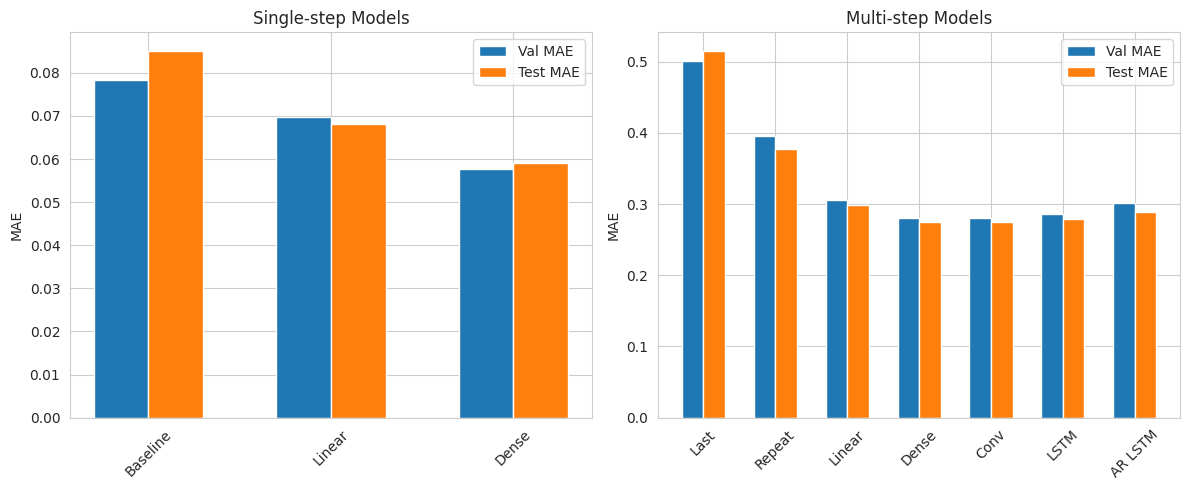

In [64]:
# Collect single-step metrics
model_names_single = list(performance.keys())
val_mae_single = [v['mae'] for v in val_performance.values()]
test_mae_single = [v['mae'] for v in performance.values()]

# Collect multi-step metrics
model_names_multi = list(multi_performance.keys())
val_mae_multi = [v['mae'] for v in multi_val_performance.values()]
test_mae_multi = [v['mae'] for v in multi_performance.values()]

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
width = 0.3

# Single-step bar chart
x_s = np.arange(len(model_names_single))
axs[0].bar(x_s - width/2, val_mae_single, width, label='Val MAE')
axs[0].bar(x_s + width/2, test_mae_single, width, label='Test MAE')
axs[0].set_xticks(x_s)
axs[0].set_xticklabels(model_names_single, rotation=45)
axs[0].set_ylabel('MAE')
axs[0].set_title('Single-step Models')
axs[0].legend()

# Multi-step bar chart
x_m = np.arange(len(model_names_multi))
axs[1].bar(x_m - width/2, val_mae_multi, width, label='Val MAE')
axs[1].bar(x_m + width/2, test_mae_multi, width, label='Test MAE')
axs[1].set_xticks(x_m)
axs[1].set_xticklabels(model_names_multi, rotation=45)
axs[1].set_ylabel('MAE')
axs[1].set_title('Multi-step Models')
axs[1].legend()

plt.tight_layout()
plt.show()

## 10) Conclusão
1. **Single-step**:
   - Modelos como baseline, linear e denso podem ter desempenho razoável prevendo apenas 1 hora no futuro.
2. **Multi-step** (24h):
   - Precisamos de mais complexidade ou estratégias (ex.: single-shot ou autoregressivo) para lidar com a evolução de um dia inteiro.
3. **Comparação** mostra que, em muitos casos, os modelos básicos (linear, denso) já atingem bons resultados, e CNN/LSTM podem trazer ganhos marginais dependendo da natureza dos dados.

### Possíveis Extensões
- Explorar **horizontes diferentes** (ex.: 48h, 72h).
- Incluir **MLflow** para rastrear experimentos.
- Servir o modelo com **FastAPI**.
- Ajustar hiperparâmetros.

Com isso, cobrimos tanto o **single-step** quanto o **multi-step** em um único pipeline.